# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Ref 
[link](https://github.com/hamadalaqeel/Starbuck-s-Capstone-Project/blob/master/Starbucks_Capstone_notebook.ipynb)

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Business Understanding

The objective here is to find patterns and show when and where to give specific offer to a specific customer.

In [1]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Data Cleaning
## 1.1. Porfolio
- Update the name of the id column to offer_id.
- Divide the channels into a number of columns.
- Offer_type should be split across different columns.


In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
# Update the name of the id column to offer_id.
portfolio.rename(columns={'id':'offer_id'},inplace=True)

# Divide the channels into a number of columns.
channel_dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack(), prefix='channel').sum(level=0)
portfolio = pd.concat([portfolio,channel_dummies],axis=1)
portfolio.drop(columns=['channels'],inplace=True)

# Result:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


## 1.2. Profile
- Replace the name "id" with "customer_id".
- Fix the date.
- Irregular ages in the "age" column.
- In the gender and income columns, there are 17,000 - 14,825 = 2,175 missing values.

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [10]:
# Replace the name "id" with "customer_id".
profile.rename(columns={'id':'customer_id'},inplace=True)

# Fix the date.
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x),format='%Y%m%d'))

profile['income'].fillna((profile['income'].mean()), inplace=True)

# Some customers who has the irregular ages. Take them out of the concern by adding a new column - "valid"
ages = profile['age'].unique()
perct_old_ages = profile['age'][profile['age'] > 100].count()/profile['age'].count() * 100
print('''
Unique ages in the df: {},
% customers who has the age > 100: {} %
'''.format(ages, round(perct_old_ages,2)))
profile['valid'] = profile['age'].apply(lambda x: 1 if x <= 100 else 0)

# Result:
profile.head()




Unique ages in the df: [118  55  75  68  65  58  61  26  62  49  57  40  64  78  42  56  33  46
  59  67  53  22  96  69  20  45  54  39  41  79  66  29  44  63  36  76
  77  30  51  27  73  74  70  89  50  90  60  19  72  52  18  71  83  43
  47  32  38  34  85  48  35  82  21  24  81  25  37  23 100  28  84  80
  87  86  94  31  88  95  93  91  92  98 101  97  99],
% customers who has the age > 100: 12.82 %



,age,became_member_on,gender,customer_id,income,valid
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,1
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,1
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,65404.991568,0


## 1.3. Transcript
- Rename the "person" column to "customer_id".
- Get dummies for "event" column.
- Unlist the values in "value" column.



In [11]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [12]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [13]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [14]:
# Rename the "person" column to "customer_id".
transcript.rename(columns={'person':'customer_id'},inplace=True)

# Unlist the values in "value" column.
transcript['offer_id'] = [list(x.values())[0]  if (list(x.keys())[0] in ['offer_id', 'offer id']) else np.nan for x in transcript['value']]
transcript['amount'] = [list(x.values())[0]  if (list(x.keys())[0] in ['amount']) else np.nan for x in transcript['value']]
transcript.drop(columns=['value'],inplace=True)


# Result:
transcript.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


## 1.4. Merge datasets

In [15]:
df = pd.merge(transcript, profile, on='customer_id', how="left")
df = pd.merge(df, portfolio, on='offer_id', how="left")
df.head()

,event,customer_id,time,offer_id,amount,age,became_member_on,gender,income,valid,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.000000,1,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,2017-08-04,None,65404.991568,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,68,2018-04-26,M,70000.000000,1,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,118,2017-09-25,None,65404.991568,0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,2017-10-02,None,65404.991568,0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [16]:
# Simplify the offer_id:
offer_ids = df['offer_id'].unique()
cnt = 1
offer_list = {}
for offer in offer_ids:
    offer_list[offer] = 'X'+str(cnt)
    cnt += 1
df['offer_id'] = df['offer_id'].apply(lambda x: offer_list[x] if (x in offer_list.keys()) else x)

# Simplify the customer_id:
customer_ids = profile['customer_id'].unique()
count = 1
customer_list = {}
for cus in customer_ids:
    customer_list[cus] = 'A'+str(count)
    count += 1
df['customer_id'] = df['customer_id'].apply(lambda x: customer_list[x] if (x in customer_list.keys()) else x)

# Add "age_group" for analysis purpose
df['age_group'] = pd.cut(df['age'], bins=[0, 12, 18, 21, 64, 200], 
                        labels=['child', 'teen', 'young adult', 'adult', 'elderly'])

df.head()

,event,customer_id,time,offer_id,amount,age,became_member_on,gender,income,valid,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,age_group
0,offer received,A4,0,X1,NaN,75,2017-05-09,F,100000.000000,1,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,elderly
1,offer received,A5,0,X2,NaN,118,2017-08-04,None,65404.991568,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,elderly
2,offer received,A6,0,X3,NaN,68,2018-04-26,M,70000.000000,1,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,elderly
3,offer received,A7,0,X4,NaN,118,2017-09-25,None,65404.991568,0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,elderly
4,offer received,A8,0,X5,NaN,118,2017-10-02,None,65404.991568,0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,elderly


# 2. Analyze
## 2.1.  Univariate Exploration:

1. What is the average income of a Starbucks customer?
2. What is the average Starbucks customer's age?
3. Which of the following promotions is the most common?
4. What are the most common values in each column of each dataframe?
5. In terms of transcripts, who is the most loyal customer?

Let's start with the first question:

**1. What is the average income of a Starbucks customer?**

In [17]:
print('The average income for Starbucks customers: ', round(profile['income'].mean(),2))

The average income for Starbucks customers:  65404.99


**2. What is the average Starbucks customer's age?**

In [18]:
print('The average age for Starbucks customers: ', round(profile['age'].mean(),2))

The average age for Starbucks customers:  62.53


**3. Which of the following promotions is the most common?**

Bogo and Discount seem the most and they are close to each other with bogo been slightly higher

In [19]:
def addlabels(x,y,rotation='horizontal'):
    '''
    INPUT:
    - x: an array of x labels
    - y: an array of y values
    - rotation: the default is 'horizontal', could be changed to 'vertical' or a number of degree.
    OUTPUT: the label values attached in each bar column.
    '''
    for i in range(len(x)):
        plt.text(i,y[i]//2,y[i],horizontalalignment='center')

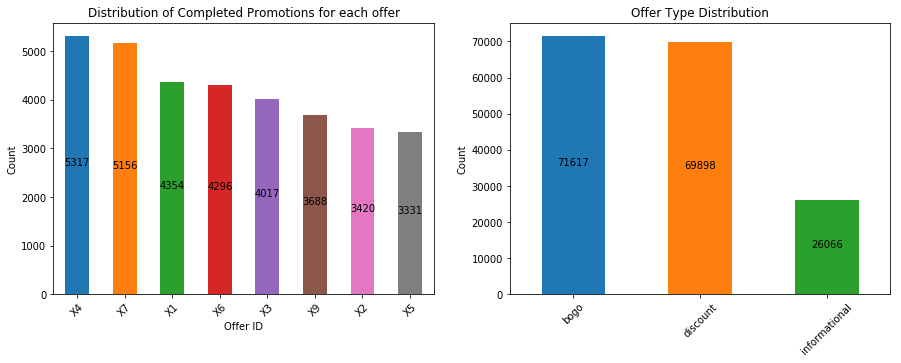

In [20]:
# Check the completed orders only

plt.subplot(121)
count_offer_id = df[df['event'] == 'offer completed']['offer_id'].value_counts()
count_offer_id.plot(kind='bar',figsize=(15, 5), rot=45)
plt.xlabel('Offer ID')
plt.ylabel('Count')
plt.title('Distribution of Completed Promotions for each offer')
addlabels(count_offer_id.index, count_offer_id.values);

plt.subplot(122)
count_offer_type = df['offer_type'].value_counts()
count_offer_type.plot(kind='bar',figsize=(15, 5), rot=45)
# plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.title('Offer Type Distribution')
addlabels(count_offer_type.index, count_offer_type.values);



**4. What are the most common values in each column of each dataframe?**

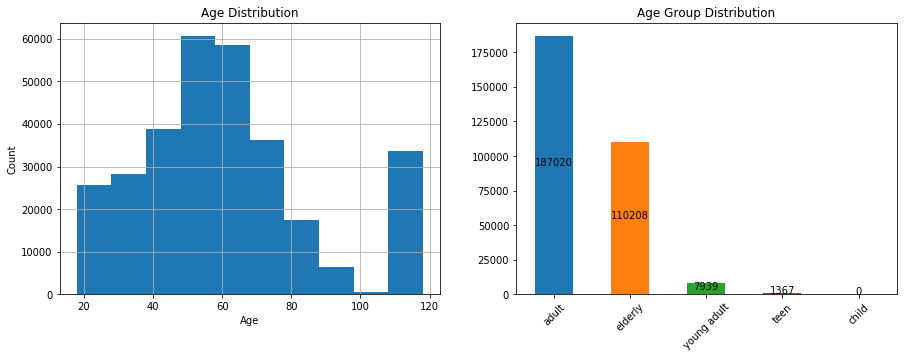

In [21]:
plt.subplot(121)
df['age'].hist()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution');

plt.subplot(122)
count_age_group = df['age_group'].value_counts()
count_age_group.plot(kind='bar',figsize=(15, 5), rot=45)
# plt.xlabel('Age Group')
# plt.ylabel('Count')
plt.title('Age Group Distribution')
addlabels(count_age_group.index, count_age_group.values);



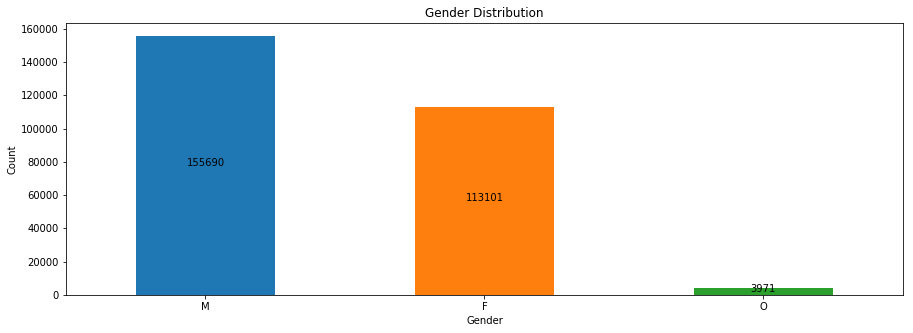

In [22]:
gender_count = df['gender'].value_counts()
gender_count.plot(kind='bar',figsize=(15, 5), rot=0)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
addlabels(gender_count.index, gender_count.values);

Most are Adults and Males, interesting...

**5. In terms of transcripts, who is the most loyal customer?**


    Profile ID: A14827,
    Number of Completed Offers: 5,
    Amount: 1608.69
    

    Profile ID: A13476,
    Number of Completed Offers: 6,
    Amount: 1365.66
    

    Profile ID: A10782,
    Number of Completed Offers: 3,
    Amount: 1327.74
    

    Profile ID: A10653,
    Number of Completed Offers: 4,
    Amount: 1321.42
    

    Profile ID: A10310,
    Number of Completed Offers: 5,
    Amount: 1319.97
    


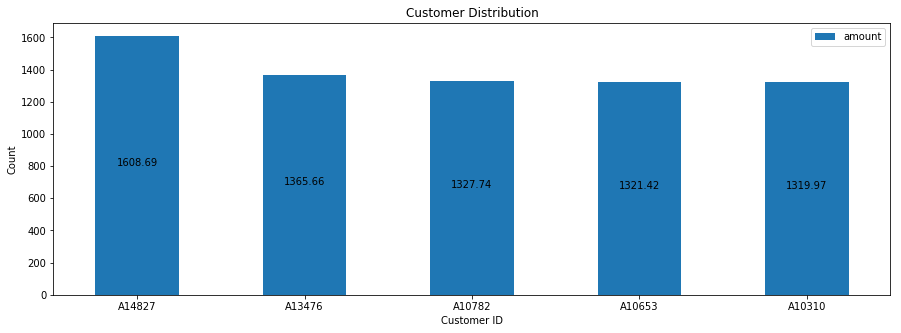

In [23]:
loyal_customer_count = df[(df['event'] == 'offer completed') | (df['event'] == 'transaction')].groupby(['customer_id', 'event'])['amount'].sum().reset_index()
loyal_customer_count = loyal_customer_count.sort_values('amount',ascending=False).head()

# Visualize
loyal_cus = loyal_customer_count.set_index('customer_id')
loyal_cus.plot(kind='bar',figsize=(15, 5), rot=0)
plt.xlabel('Customer ID')
plt.ylabel('Count')
plt.title('Customer Distribution')
addlabels(loyal_cus.index, loyal_cus['amount']);

for cus in loyal_customer_count['customer_id']:
    print('''
    Profile ID: {},
    Number of Completed Offers: {},
    Amount: {}
    '''.format(cus
               ,df[df['event'] == 'offer completed'].groupby('customer_id')['offer_id'].count().loc[cus]
               ,round(loyal_customer_count[loyal_customer_count['customer_id']==cus]['amount'].values[0], 2))
         )

    

## 2.2. Multvariate Exploration

1. What is the most popular promotion among children, teenagers, young adults, adults, and the elderly?
2. Which gender earns more money from profiles, guys or females?
3. What kinds of promotions do each gender prefer?

**1. What is the most popular promotion among children, teenagers, young adults, adults, and the elderly?**

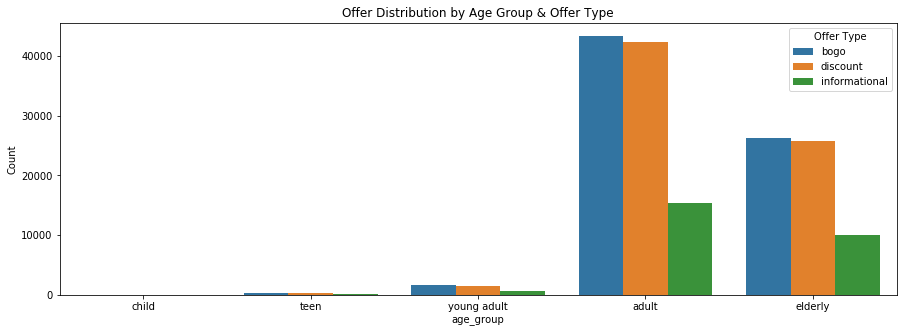

In [24]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x='age_group', hue='offer_type')
plt.title('Offer Distribution by Age Group & Offer Type')
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

**2. Which gender earns more money from profiles, guys or females?**

Note: Exclude N/A because they didn't tell their gender

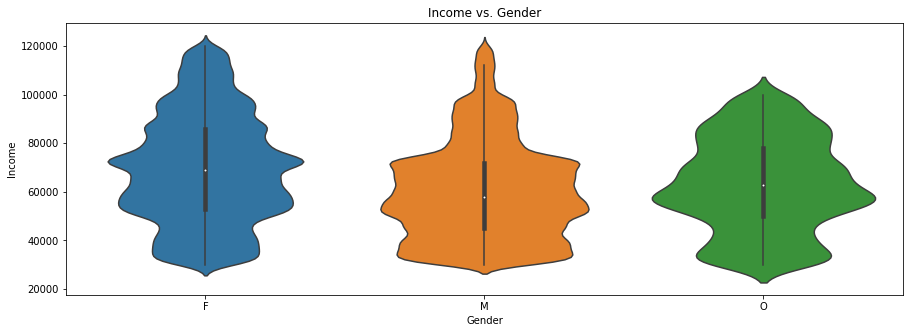

In [25]:
plt.figure(figsize=(15, 5))
sns.violinplot(x=df[df['gender'] != 'NA']['gender'], y=df['income'])
plt.title('Income vs. Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

**Note:** The median is shown by the `white dot` in each graph.

**3. What kinds of promotions do each gender prefer?**

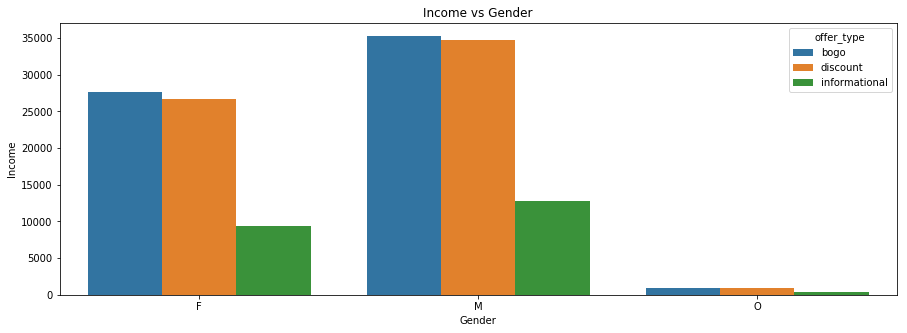

In [26]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x=df[df['gender'] != 'NA']['gender'], hue = 'offer_type')
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

# 3. Simple Linear Regression Machine Learning Model

Based on consumer age, income, and gender, the model attempts to forecast **amount spent per transaction.**

In [27]:
df.head()

,event,customer_id,time,offer_id,amount,age,became_member_on,gender,income,valid,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,age_group
0,offer received,A4,0,X1,NaN,75,2017-05-09,F,100000.000000,1,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,elderly
1,offer received,A5,0,X2,NaN,118,2017-08-04,None,65404.991568,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,elderly
2,offer received,A6,0,X3,NaN,68,2018-04-26,M,70000.000000,1,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,elderly
3,offer received,A7,0,X4,NaN,118,2017-09-25,None,65404.991568,0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,elderly
4,offer received,A8,0,X5,NaN,118,2017-10-02,None,65404.991568,0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,elderly


In [28]:
# Extract df for the model
df_ml = df[['amount','gender','age','income','event']]
df_ml = pd.concat([pd.get_dummies(df_ml['event']), df_ml.drop(columns=['event'])], axis=1)
df_ml = df_ml[['amount','gender','age','income','transaction']]

df_ml = df_ml[(df_ml['transaction'] == 1) & (df_ml['gender'] != 'O')]
df_ml = pd.concat([pd.get_dummies(df_ml['gender']), df_ml.drop(columns=['gender'])], axis=1)
df_ml.drop(columns=['transaction'], axis=1, inplace=True)

df_ml.head()

,F,M,amount,age,income
12654,1,0,0.83,20,30000.0
12657,0,1,34.56,42,96000.0
12659,0,1,13.23,36,56000.0
12670,1,0,19.51,55,94000.0
12671,1,0,18.97,39,67000.0


In [29]:
# Check NaN values
df_ml.isnull().mean()

F         0.0
M         0.0
amount    0.0
age       0.0
income    0.0
dtype: float64

In [30]:
# Define features and target as well as split train/test data
X = df_ml.drop('amount', axis=1)
y = df_ml['amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

scores = dict()

In [31]:
# No Scaling/Normalization Approach

# Instantiate, Fit & Predict
lr_dumb = LinearRegression(normalize=True) 
lr_dumb.fit(X_train, y_train) 
y_test_preds = lr_dumb.predict(X_test) 

scores['No Scaling/Normalization'] = round(r2_score(y_test, y_test_preds),2)

print(
'''
No Scaling/Normalization: 
r-square score: {} on {} values.'''.format(round(r2_score(y_test, y_test_preds),2), len(y_test))
)


No Scaling/Normalization: 
r-square score: 0.07 on 41152 values.


In [32]:
# Normalization approach

# Fit scaler on the training data
norm = MinMaxScaler().fit(X_train)

# Transform
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

# Instantiate, Fit & Predict
lr_norm = LinearRegression(normalize=True) 
lr_norm.fit(X_train_norm, y_train) 
y_test_preds = lr_norm.predict(X_test_norm) 

scores['Normalization'] = round(r2_score(y_test, y_test_preds),2)

print(
'''
Normalization: 
r-square score: {} on {} values.'''.format(round(r2_score(y_test, y_test_preds),2), len(y_test))
)



Normalization: 
r-square score: 0.07 on 41152 values.


In [33]:
# Scalarization approach

X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# Apply standardization on numerical features
num_cols = ['age','income']
for i in num_cols:
    # Fit on training data column
    scale = StandardScaler().fit(X_train[[i]])
    
    # Transform
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    X_test_stand[i] = scale.transform(X_test_stand[[i]])
    
#Instantiate, Fit & Predict
lr_stand = LinearRegression(normalize=True) 
lr_stand.fit(X_train_stand, y_train) 
y_test_preds = lr_stand.predict(X_test_stand)

scores['Scalarization'] = round(r2_score(y_test, y_test_preds),2)

print(
'''
Scalarization: 
r-square score: {} on {} values.'''.format(round(r2_score(y_test, y_test_preds),2), len(y_test))
)




Scalarization: 
r-square score: 0.07 on 41152 values.


In [34]:
score_df = pd.DataFrame()
score_df['model type'] = scores.keys()
score_df['r-square value'] = scores.values()
score_df

,model type,r-square value
0,No Scaling/Normalization,0.07
1,Normalization,0.07
2,Scalarization,0.07


## Conclusion

The r-squared score was the same for all three ways. Let's take a look at the identical r-squared score as the previous item. In a linear regression model, characteristics are not assigned more weight based on their magnitude, as they would be in a distance-based method. Each feature converges on a minima in a linear regression model, which is a type of gradient descent model. When not scaled, the pace of descent and step size of each feature can vary. This does not give larger magnitude features a higher weight than lower magnitude features, but it can hurt model performance because some features decline to the minima faster than others. Scaling numerical data in a linear regression model is generally a good idea to improve model stability and convergence time. However, as the results in the preceding section show, it is not necessary in terms of feature weighting.


The r-squared value will be discussed in the second item. The r-squared number is based on a 0 to 100 percent scale, as described in the metrics section. The better the correlation and model accuracy in predicting, the higher the percentage. As a result, there is little link between consumer amount spent per transaction and age, gender, or annual income in the model above.

## Improvements

I believe I've arrived to a position where I have strong outcomes and a decent grasp of the data. However, in order to improve our results, I would strive to improve my data collecting and resolve any issues I have with NaN values. I'll also try to obtain further information, such as the place and time the transaction was made, as well as the branch and time of day. All of this information can assist us in determining when and where we should make our proposals.